# Version History

VERSION 0.3:
* Removed current_solution initialization from the constructor.
* Added num_neighbor to control the number of neighbors generated per iteration.
* Added best_score_idx, a lambda function to find the index of the best score from a list of scores. This is used when evaluating multiple neighbors.
* The current solution is now initialized at the start of the fit method.
* Generates multiple neighbors (num_neighbor) per iteration and evaluates them.
* Selects the best neighbor based on the scores and updates the current and best solutions if necessary.
* Implements the random restart mechanism. It calls fit method multiple times (num_restarts) and keeps track of the overall best solution.


VERSION 0.2:
* Introduced the mode parameter to toggle between maximization and minimization.
* Added a lambda function, is_better, to abstract the comparison logic based on the mode.
* The best_score is now set based on the mode of operation.
* The fit method is updated to use the is_better function for comparison.



VERSION 0.1:
* Basic hill climbing functionality to maximize an objective function.
* The fit method only seeks to improve (maximize) the objective function score.
* The best_score is initialized to negative infinity to ensure any score is better.


# Hill Climber Class

|   | Hill Climbing Algorithm | Neighbor Generation                       | Number of Neighbors    | Termination                                   | Exploration vs. Exploitation |
|---|-------------------------|-------------------------------------------|------------------------|-----------------------------------------------|------------------------------|
| V | First-choice            | Random neighbor, stops when better found  | 1 until better found   | No improvement for a set number of iterations | Mostly exploitation          |
| V | Steepest Ascent         | All possible neighbors, best selected     | All possible neighbors | No better neighbor found                      | Pure exploitation            |
|   | Gradient Descent        | Next point based on gradient              | 1                      | No improvement in next step                   | Pure exploitation            |
|   | Stochastic              | Multiple neighbors, chosen stochastically | Multiple               | No improvement for a set number of iterations | Mostly exploitation          |
|   | Simulated Annealing     | Random neighbor                           | 1                      | Temperature reaches zero or eval limit        | Balanced                     |



<img src="https://www.researchgate.net/profile/John-Hogden/publication/291419889/figure/fig2/AS:320895026515974@1453518744135/Schematic-showing-the-trade-off-between-exploration-and-exploitation-A-hypothetical.png" width=400>

> Schematic showing the trade-off between **exploration** and **exploitation**.: A hypothetical fitness landscape (shown as continuous red line) from the regression model in an abstract high-dimensional feature space with two local maxima. One of the maxima has a data point with a relatively large value for mean, but small uncertainty (error bar). This is due to its close proximity to the best material that is known so far in the training set (blue circle), where the regression algorithm has trained well. The other local maximum, in contrast, has a data point with small mean value (red circle), but relatively large uncertainty.

Prasanna V. Balachandran et. al., Adaptive Strategies for Materials Design using Uncertainties (2016)

In [11]:
import numpy as np

In [1]:
class HillClimber:
  def __init__(self, generate_neighbor,
                objective_function,
                initial_solution_generator,
                step_size=0.1,
                num_neighbors=1,
                learning_rate=0.01,
                max_iter=1000,
                mode='max',
                num_restarts=10,
                ):
    self.generate_neighbor = generate_neighbor
    self.objective_function = objective_function
    self.initial_solution_generator = initial_solution_generator
    self.step_size = step_size
    self.num_neighbors = num_neighbors
    self.max_iter = max_iter
    self.best_solution = None
    self.best_score = None
    self._setup_mode(mode)
    self.num_restarts = num_restarts

  def _setup_mode(self, mode):
    if mode == 'max':
      self.best_score = float('-inf')
      self.is_better = lambda new, best: new > best
      self.best_score_idx = lambda scores: np.argmax(scores)
    else:
      self.best_score = float('inf')
      self.is_better = lambda new, best: new < best
      self.best_score_idx = lambda scores: np.argmin(scores)

  def fit(self):
    self.current_solution = self.initial_solution_generator()
    for _ in range(self.max_iter):
      neighbors = self.generate_neighbor(solution=self.current_solution, step_size=self.step_size, num_neighbors=self.num_neighbors)
      neighbors_scores = [self.objective_function(neighbor) for neighbor in neighbors]
      best_neighbor_index = self.best_score_idx(neighbors_scores)
      best_neighbor = neighbors[best_neighbor_index]

      if self.is_better(neighbors_scores[best_neighbor_index], self.best_score):
        self.best_solution = best_neighbor
        self.best_score = neighbors_scores[best_neighbor_index]
        self.current_solution = best_neighbor

    return self.best_solution

  def predict(self):
    return self.best_solution

  def score(self):
    return self.best_score

  def random_restart(self):
    for _ in range(self.num_restarts):
      self.fit()
      new_solution = self.predict()
      new_score = self.score()

      if self.is_better(new_score, self.best_score):
        self.best_solution = new_solution
        self.best_score = new_score

#3. GradientDescentHillClimber

GradientDescentHillClimber class using the convex_function as the objective function. We will test these classes to see if they can minimize this function, starting from a random initial solution in a 5-dimensional space.

```
def convex_function(x):
    return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2
```

## Numerical_differentiation

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Derivative.svg/460px-Derivative.svg.png" width=400>

https://en.wikipedia.org/wiki/Numerical_differentiation

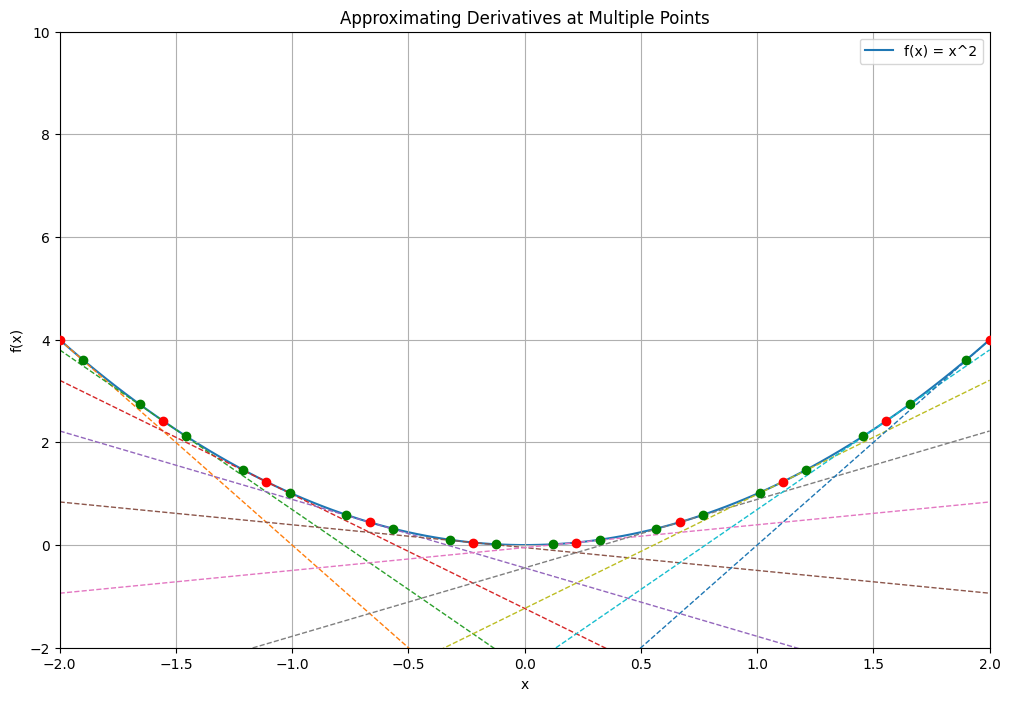

In [2]:
class GradientDescentHillClimber(HillClimber):
    def __init__(self, gradient_function, objective_function, initial_solution_generator, step_size=0.1, num_neighbor=1, learning_rate=0.01, max_iter = 1000, mode = 'min', num_restarts = 10):
        super().__init__(gradient_function, objective_function, initial_solution_generator, step_size, num_neighbor, learning_rate, max_iter, mode, num_restarts)


In [3]:
from functools import partial
import numpy as np

def convex_function(x):
  return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2

def initial_solution_generator(n=5):
  return [np.random.uniform(-30, 30) for _ in range(n)]

# Numerical gradient approximation function
def numerical_gradient(f, solution, step_size=0.1, num_neighbors=1, learning_rate=0.01, h=1e-5):
  neighbors = np.array([])
  solution = np.array(solution)

  z = (f(solution + h) - f(solution)) / h

  value = z * learning_rate

  # print(value)

  # for i in solution:
  #   print(i)
  #   print("--------------")

  print(solution)

  if z > 0:
    neighbors = solution - value
  elif z < 0:
    neighbors = solution + value
  
  # print(neighbors)
  return [neighbors]
  # return [solution]
  pass

initial_solution_generator = partial(initial_solution_generator, 5)
objective_function = partial(numerical_gradient, f=convex_function)

# Test the GradientDescentHillClimber class
hill_climber = GradientDescentHillClimber(
    gradient_function=objective_function,
    objective_function=convex_function,
    initial_solution_generator=initial_solution_generator,
)

hill_climber.fit()

print(f"Gradient Descent Hill Climber Best Solution: {hill_climber.predict()}")
print(f"Gradient Descent Hill Climber Best Score: {hill_climber.score():.5f}")

[ -7.07635295 -14.65328949  -3.19295248  17.65869349  11.76428675]
[ -7.38986286 -14.9667994   -3.5064624   17.34518357  11.45077684]
[ -7.55915822 -15.13609476  -3.67575775  17.17588822  11.28148148]
[ -7.6505777  -15.22751425  -3.76717724  17.08446873  11.19006199]
[ -7.69994423 -15.27688077  -3.81654376  17.0351022   11.14069547]
[ -7.72660215 -15.3035387   -3.84320169  17.00844428  11.11403754]
[ -7.74099743 -15.31793398  -3.85759697  16.994049    11.09964226]
[ -7.74877088 -15.32570743  -3.86537042  16.98627555  11.09186881]
[ -7.75296855 -15.32990509  -3.86956808  16.98207789  11.08767115]
[ -7.75523528 -15.33217183  -3.87183482  16.97981115  11.08540441]
[ -7.75645932 -15.33339587  -3.87305886  16.97858711  11.08418037]
[ -7.7571203  -15.33405685  -3.87371984  16.97792613  11.08351939]
[ -7.75747723 -15.33441378  -3.87407677  16.9775692   11.08316246]
[ -7.75766997 -15.33460652  -3.87426951  16.97737646  11.08296972]
[ -7.75777406 -15.3347106   -3.87437359  16.97727238  11.08286

In [28]:
help(numerical_gradient)

Help on function numerical_gradient in module __main__:

numerical_gradient(f, solution, step_size=0.1, num_neighbors=1, learning_rate=0.01, h=1e-05)
    # Numerical gradient approximation function



# 1. FirstChoiceHillClimber

Given the base class HillClimber, implement a FirstChoiceHillClimber class that extends the functionality of hill climbing by selecting the first neighboring solution that is better than the current solution. Override the fit method to perform the hill climbing process, predict to return the best solution found, and score to return the objective value of the best solution.

In [ ]:
class FirstChoiceHillClimber(HillClimber):
  pass

#2. SteepestAscentHillClimber


Using the provided HillClimber class, create a SteepestAscentHillClimber class that finds the best neighbor out of all possible neighbor solutions generated in one iteration and moves to it if it is better than the current solution. Implement fit, predict, and score methods according to the class' operations.

# 4. RandomRestartHillClimber ??

Random Restart is a strategy used to overcome the limitations of local search algorithms, which might get stuck in local optima. The idea is to run a local search algorithm repeatedly from different random starting points.

> Compared to these algorithms (FirstChoice, Steepest, GradientDescent), the random restart mechanism is actually a different approach.

```
for _ in range(num_restarts):
  algorithm.fit()
  new_solution = algorithm.predict()
  new_score = algorithm.score()
  if (is_better(best_score, new_score):
    best_solution = new_solution
    best_score = new_score
```

# Evaluation Functions



| Ackley | Griewank | Convex |
|------|----------|-----|
| <img src="https://drive.google.com/uc?id=1M1slit0Toi9fSt5A_XFPLHdC73vue9-_" width="400"/>   | <img src="https://drive.google.com/uc?id=1dz2iCffrUXVa7bB4ohxjvDXPp3ud0vTO" width="400"/>      |   <img src="https://drive.google.com/uc?id=1FRXc3t5WQlKRWHT_sj7xfhocITK3-RoW" width="400"/>  |

```
def ackley_function(x):
    term1 = -20 * math.exp(-0.2 * math.sqrt(sum(xi ** 2 for xi in x) / len(x)))
    term2 = -math.exp(sum(math.cos(2 * math.pi * xi) for xi in x) / len(x))
    return 20 + math.e + term1 + term2

def convex_function(x):
    return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2

def griewank_function(x):
    sum_term = sum(xi ** 2 for xi in x) / 4000
    prod_term = math.cos(x[0])
    for i, xi in enumerate(x[1:], start=2):
        prod_term *= math.cos(xi / math.sqrt(i))
    return 1 + sum_term - prod_term
```



# 0. Discrete Problem Test

In [ ]:
cities = [
    (8, 31), (54, 97), (50, 50), (65, 16), (70, 47), (25, 100), (55, 74), (77, 87),
    (6, 46), (70, 78), (13, 38), (100, 32), (26, 35), (55, 16), (26, 77), (17, 67),
    (40, 36), (38, 27), (33, 2), (48, 9), (62, 20), (17, 92), (30, 2), (80, 75),
    (32, 36), (43, 79), (57, 49), (18, 24), (96, 76), (81, 39)
]



hc = hill_climber(
            generate_neighbor=generate_neighbor,
            objective_function=objective_function,
            initial_solution_generator=initial_solution_generator,
            mode='min'
        )
hc.fit()
print(f"First Choice Hill Climber Best Solution: {hc.predict()}")
print(f"First Choice Hill Climber Best Score: {hc.score()}")